In [ ]:
pip install tweepy

In [ ]:
import tweepy
import pandas as pd
# import gspread
import os

In [ ]:
# Replace with your actual credentials
consumer_key = "S0CBYM7CeNrFPYAjaXHT7jQtW"
consumer_secret = "ZIqidLF5rZ1pgEpBtrGSEsubqj9N5j2x7J5gbTbcXLS9Zz3xsi"
access_token = "1967585008912420864-I3wfdM4VI2nQ3dv2leByVbmfniOVYp"
access_token_secret = "QKlQOcBj0oHB3ZkZJlVRKyFWMFAgbBfJOuWkTyaLnnJj7"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAEfm5QEAAAAAdXFUlgRY6VgnuN5urfFOVYyUAS8%3DqC9LnWDto3rJR5z74GivaypVZHycTzHybFV2muhq068lrb6zOs"

try:
    # Authenticate with the Twitter API
    auth = tweepy.OAuth1UserHandler(
        consumer_key,
        consumer_secret,
        access_token,
        access_token_secret,
        bearer_token
    )
    api = tweepy.API(auth)

    # Verify credentials (optional but recommended)
    api.verify_credentials()
    print("Authentication successful!")

except tweepy.TweepyException as e:
    print(f"Error during authentication: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Authentication successful!


In [ ]:
import tweepy
import pandas as pd

# --- sudah ada di kamu ---
client = tweepy.Client(bearer_token)

search_query = "#MBG lang:id -is:retweet"

try:
    response = client.search_recent_tweets(
        query=search_query,
        max_results=100,
        tweet_fields=["created_at", "lang", "public_metrics"]
    )

    tweets = response.data

    if tweets:
        rows = []
        for tweet in tweets:
            rows.append({
                "tweet_id": tweet.id,
                "created_at": tweet.created_at,
                "lang": tweet.lang,
                "text": tweet.text,
                "retweet_count": tweet.public_metrics.get("retweet_count", 0),
                "reply_count": tweet.public_metrics.get("reply_count", 0),
                "like_count": tweet.public_metrics.get("like_count", 0),
                "quote_count": tweet.public_metrics.get("quote_count", 0),
            })

        df = pd.DataFrame(rows)
        print("Jumlah tweet:", len(df))
        print(df.head())
    else:
        print("Found 0 tweets.")
        df = pd.DataFrame()  # biar variabel df tetap ada

except tweepy.TweepyException as e:
    print(f"Error during tweet search: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Jumlah tweet: 100
              tweet_id                created_at lang  \
0  1990342656632017256 2025-11-17 08:54:02+00:00   in   
1  1990342624071602548 2025-11-17 08:53:55+00:00   in   
2  1990342597945311463 2025-11-17 08:53:48+00:00   in   
3  1990338324654162190 2025-11-17 08:36:49+00:00   in   
4  1990331266705854609 2025-11-17 08:08:47+00:00   in   

                                                text  retweet_count  \
0  Bersama MBG, kita wujudkan langkah nyata untuk...              0   
1  Bersama MBG, kita wujudkan langkah nyata untuk...              0   
2  Bersama MBG, kita wujudkan langkah nyata untuk...              0   
3  Dua #SPPG di Kota Malang Liburkan Operasional ...              0   
4  Tanda-tanda gejolak pasokan dan harga pangan a...              3   

   reply_count  like_count  quote_count  
0            0           0            0  
1            0           0            0  
2            0           0            0  
3            0           0            0  
4 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL SENTIMEN MULTILINGUAL ROBERTA
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()

id2label = {0: "negative", 1: "neutral", 2: "positive"}

def indo_roberta_sentiment(text, max_length=128):
    if not isinstance(text, str) or text.strip() == "":
        return "neutral", 0.0

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_length
    ).to(device)

    with torch.no_grad():
        logits = model(**inputs).logits

    probs = softmax(logits, dim=1).cpu().numpy()[0]
    idx = probs.argmax()
    return id2label[idx], float(probs[idx])


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [ ]:
from tqdm.auto import tqdm

translated_texts = []
evaluations = []
probs = []

for text in tqdm(df["text"], desc="Analyse", position=0, leave=True):

    label, prob = indo_roberta_sentiment(text)
    evaluations.append(label)
    probs.append(prob)

df["Evaluation"] = evaluations
df["Prob"] = probs

if "created_at" in df.columns:
    df_final = df.sort_values("created_at").reset_index(drop=True)
else:
    df_final = df.reset_index(drop=True)

df_final = df_final[["created_at", "tweet_id", "text", "Evaluation", "Prob"]]
df_final.head(100)


Analyse:   0%|          | 0/100 [00:00<?, ?it/s]

,created_at,tweet_id,text,Evaluation,Prob
0,2025-11-16 18:10:46+00:00,1990120374881931754,Sempat Ditutup karena Ratusan Siswa Diduga Ker...,negative,0.512508
1,2025-11-16 20:42:20+00:00,1990158517224006042,Mang pantas ya mentri buat statment bgini untu...,negative,0.781735
2,2025-11-16 22:00:00+00:00,1990178063683141645,📈 Ketika permintaan naik tapi pasokan tak bert...,negative,0.594069
3,2025-11-16 23:20:14+00:00,1990198254307574055,Sbg PELAYAN RAKYAT harusnya berhati-hati dlm b...,negative,0.811082
4,2025-11-16 23:58:37+00:00,1990207913592541606,@tempodotco Makan Bergizi Gratis (MBG) adalah ...,positive,0.595078
...,...,...,...,...,...
95,2025-11-17 08:08:47+00:00,1990331266705854609,Tanda-tanda gejolak pasokan dan harga pangan a...,neutral,0.691247
96,2025-11-17 08:36:49+00:00,1990338324654162190,Dua #SPPG di Kota Malang Liburkan Operasional ...,neutral,0.627993
97,2025-11-17 08:53:48+00:00,1990342597945311463,"Bersama MBG, kita wujudkan langkah nyata untuk...",positive,0.718127
98,2025-11-17 08:53:55+00:00,1990342624071602548,"Bersama MBG, kita wujudkan langkah nyata untuk...",positive,0.715876


In [ ]:
df["Evaluation"].value_counts()

,count
Evaluation,
positive,53
neutral,40
negative,7


In [ ]:
pip install wordcloud

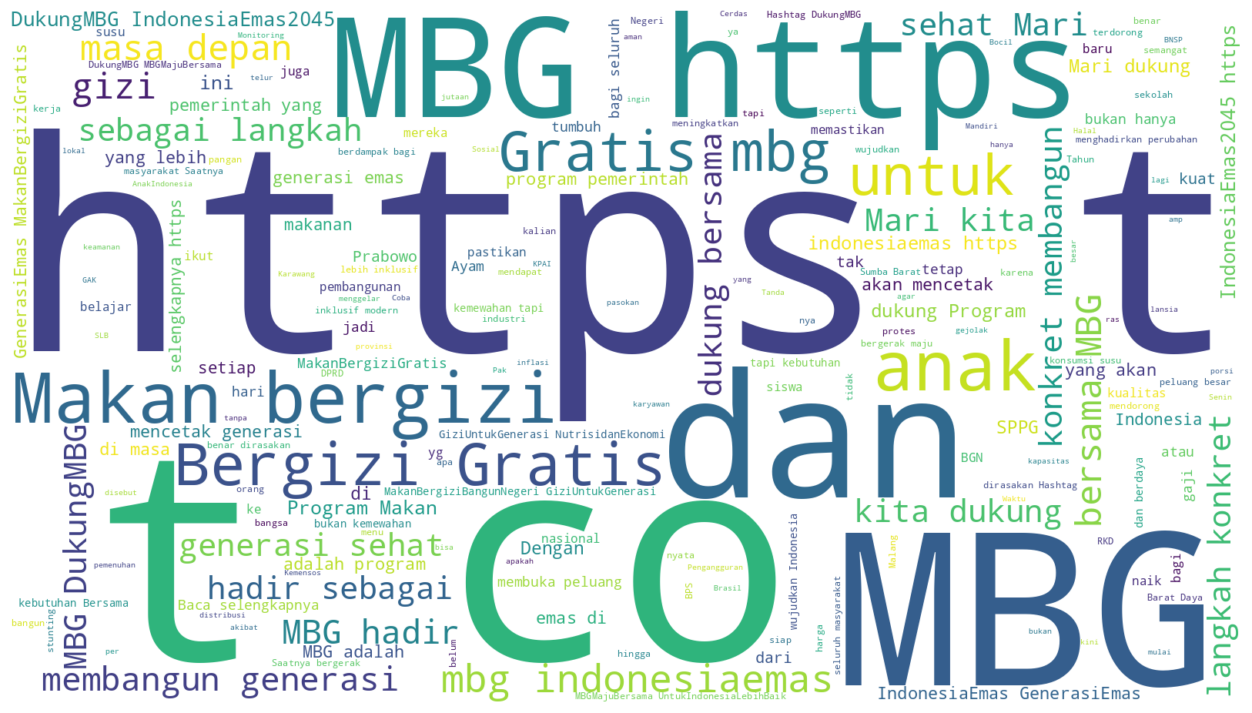

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = " ".join(df["text"].astype(str).tolist())

wc = WordCloud(
    width=1600,
    height=900,
    background_color="white",
    colormap="viridis"
).generate(all_text)

plt.figure(figsize=(16,9))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


In [ ]:
df_to_txt = df_final[["created_at", "tweet_id", "text", "Evaluation", "Prob"]]

# Nama file
filename = "Crawling MBG_X.txt"

# Tulis ke file .txt
with open(filename, "w", encoding="utf-8") as f:
    f.write("FinBERT Tweet Analysis Output\n")
    f.write("=======================================\n\n")

    for idx, row in df_to_txt.iterrows():
        f.write(f"Row {idx+1}\n")
        f.write(f"Date       : {row['created_at']}\n")
        f.write(f"Tweet ID   : {row['tweet_id']}\n")
        f.write(f"Text (ID)  : {row['text']}\n")
        f.write(f"Sentiment  : {row['Evaluation']}\n")
        f.write(f"Prob       : {row['Prob']}\n")
        f.write("---------------------------------------\n\n")

print(f"TXT saved as: {filename}")


TXT saved as: Crawling MBG_X.txt
